In [1]:
!pip install numpy

In [2]:
!pip install cvxopt

In [3]:
!pip install matplotlib

In [5]:
!pip install pandas

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)


In [35]:
## NUMBER OF ASSETS
n_assets = 100

## NUMBER OF OBSERVATIONS
n_obs = 4000

return_vec = np.random.randn(n_assets, n_obs)

In [36]:
print(return_vec)

[[ 0.83301604 -0.04252685  0.54447436 ...  0.35778142 -0.66862132
   0.93639815]
 [-0.21091914 -0.3263479  -0.75566617 ... -0.34697876  1.93122363
   0.38918679]
 [ 0.12904923 -1.21195436 -0.53048929 ...  1.00716293 -0.17801048
  -0.30754119]
 ...
 [-0.57103729  1.99388252  1.75893801 ... -0.75742683 -0.19505016
   0.35433918]
 [-0.818267   -1.13424028  0.48700366 ... -1.58246669 -1.1557431
   2.77436949]
 [ 0.17788898 -1.76138508 -0.97326699 ... -0.4050332   1.29830019
   1.88354122]]


Text(0,0.5,'returns')

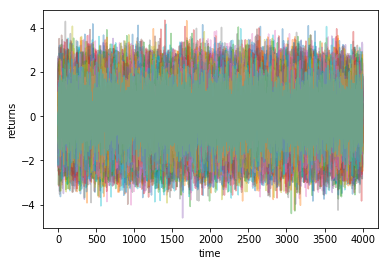

In [37]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [38]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(n_assets))
print(rand_weights(n_assets))

[7.11804235e-03 4.48663752e-03 1.77971039e-02 1.18771832e-03
 1.10008748e-02 1.01761853e-02 6.59940446e-03 1.83451007e-02
 1.69949726e-02 5.89889868e-03 5.41483707e-03 5.44785810e-03
 1.31447661e-03 4.02453910e-03 1.60640639e-02 7.52449265e-04
 1.64571366e-02 1.27733412e-02 2.73294547e-03 1.80487400e-02
 9.92302914e-03 1.60214494e-02 7.87301993e-03 1.09092479e-02
 6.40263911e-03 1.08221111e-02 5.16957295e-03 9.31735059e-03
 1.22226727e-02 1.47468016e-02 8.92312002e-03 2.23180100e-03
 9.68812478e-03 7.61750696e-03 1.43586998e-02 5.76345533e-03
 1.73353157e-02 1.01299815e-02 2.18361202e-04 1.32151955e-03
 1.50006838e-02 8.66241969e-03 1.34360852e-02 2.31841996e-03
 8.83694423e-03 7.53106956e-05 3.44232462e-03 1.75591509e-02
 9.81458338e-03 1.47578831e-02 1.45723430e-02 6.22533275e-05
 1.68921623e-02 2.54076040e-03 1.65849193e-03 1.16418838e-02
 1.84903107e-02 1.16168126e-02 1.10643634e-02 5.55950058e-04
 1.77849862e-02 1.74664382e-02 3.91376416e-03 1.69552195e-02
 1.57389364e-02 1.766454

In [39]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [40]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

Text(0.5,1,'Mean and standard deviation of returns of randomly generated portfolios')

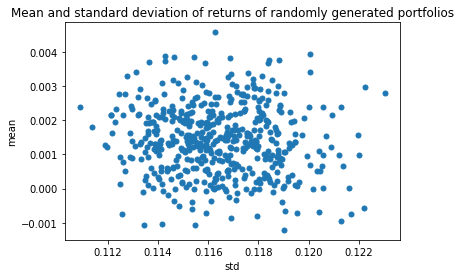

In [41]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

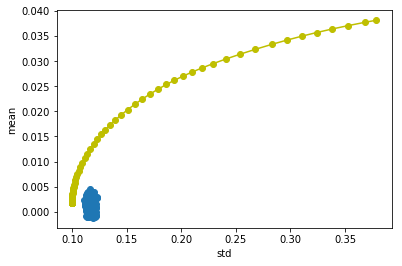

In [42]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [43]:
print(weights)


[[1.26779174e-09]
 [3.16366792e-01]
 [1.40326672e-09]
 [9.14928835e-10]
 [7.79586497e-10]
 [4.11037213e-09]
 [3.38278344e-09]
 [5.29992939e-09]
 [1.31810785e-09]
 [2.71982018e-09]
 [1.30036763e-09]
 [1.14069642e-09]
 [1.43236835e-09]
 [1.09185001e-09]
 [1.21957245e-09]
 [1.32482946e-09]
 [2.04750516e-09]
 [1.02813494e-09]
 [3.51368452e-07]
 [7.85036985e-10]
 [3.88593399e-09]
 [1.71506978e-09]
 [7.42817369e-10]
 [7.36047017e-10]
 [6.90128990e-10]
 [1.42910593e-09]
 [2.32181482e-09]
 [2.02775119e-09]
 [1.14921090e-09]
 [1.23360023e-09]
 [1.47365895e-09]
 [5.05906868e-09]
 [2.10055508e-09]
 [1.83042327e-09]
 [1.13150483e-09]
 [6.70021871e-09]
 [3.68444881e-09]
 [3.57008031e-09]
 [3.03704924e-09]
 [3.39052425e-09]
 [2.91652672e-09]
 [1.46545638e-09]
 [7.92957439e-10]
 [6.00277065e-08]
 [9.19601013e-10]
 [3.74367411e-01]
 [8.18354319e-09]
 [1.04743265e-09]
 [1.38227036e-09]
 [6.26581067e-09]
 [7.60903393e-10]
 [3.65456753e-06]
 [1.03965238e-09]
 [1.46324829e-09]
 [1.27926374e-07]
 [1.374878